# Preparando ambiente

In [1]:
from google.colab import drive
drive.mount('/content/drive')

dir_in = '/content/drive/MyDrive/2-PESQUISA/1-ORIENTACOES/IC_GUILHERME_LISBOA/famraio_brasil/'
dir_ou = '/content/drive/MyDrive/2-PESQUISA/1-ORIENTACOES/IC_GUILHERME_LISBOA/famraio_sudeste/'

Mounted at /content/drive


# Função de leitura das familias

In [2]:
# importa biblioteca
import re
import gzip

# função que extrai as informações da última linha de cada família
def extrair_resumo(resumo_str):
    pattern = (r"TOTAL TIME=\s*([\d.]+)\s+"
               r"DELTAX\s*([-.\d]+)\s+"
               r"DELTAY\s*([-.\d]+)\s+"
               r"LAST IMAGE=\s*(\w+)\s+"
               r"END=([A-Z]+).*?"
               r"TOT_IC=\s*(\d+)\s+"
               r"TOT_CGNEG=\s*(\d+)\s+"
               r"TOT_CGPOS=\s*(\d+)")

    match = re.search(pattern, resumo_str)

    if match:
        return {"TOTAL_TIME": float(match.group(1)),
                 "DELTAX": float(match.group(2)),
                 "DELTAY": float(match.group(3)),
                 "LAST_IMAGE": match.group(4),
                 "END": match.group(5),
                 "TOT_IC": int(match.group(6)),
                 "TOT_CGNEG": int(match.group(7)),
                 "TOT_CGPOS": int(match.group(8))}
    return {"raw": resumo_str}

# função de leitura da família - ZIPADO
def ler_fam_txt_gz(caminho_arquivo_gz):

    with gzip.open(caminho_arquivo_gz, 'rt', encoding='utf-8') as arquivo:  # 'rt' para ler como texto

        linhas = arquivo.readlines()

    familias = []
    familia_atual = None
    cabecalho_dados = None

    for linha in linhas:
        linha = linha.strip()

        if linha.startswith("FAMILY="):
            if familia_atual:
                familias.append(familia_atual)
            familia_atual = {"cabecalho": linha, "sistemas": []}
            cabecalho_dados = None

        elif linha.startswith("SYS#"):
            cabecalho_dados = linha.split()

        elif linha.startswith("TOTAL TIME="):
            if familia_atual:
                familia_atual["resumo"] = extrair_resumo(linha)
                familias.append(familia_atual)
            familia_atual = None
            cabecalho_dados = None

        elif cabecalho_dados and linha:
            valores = linha.split()
            sistema = dict(zip(cabecalho_dados, valores))
            familia_atual["sistemas"].append(sistema)

    return familias

# função de leitura da família - DZIPADO
def ler_fam_txt(caminho_arquivo):
    with open(caminho_arquivo, "r") as arquivo:
        linhas = arquivo.readlines()

    familias = []
    familia_atual = None
    cabecalho_dados = None

    for linha in linhas:
        linha = linha.strip()

        if linha.startswith("FAMILY="):
            if familia_atual:
                familias.append(familia_atual)
            familia_atual = {"cabecalho": linha,
                             "sistemas": []}
            cabecalho_dados = None

        elif linha.startswith("SYS#"):
            cabecalho_dados = linha.split()

        elif linha.startswith("TOTAL TIME="):
            familia_atual["resumo"] = extrair_resumo(linha)
            familias.append(familia_atual)
            familia_atual = None
            cabecalho_dados = None

        elif cabecalho_dados and linha:
            valores = linha.split()
            sistema = dict(zip(cabecalho_dados, valores))
            familia_atual["sistemas"].append(sistema)

    return familias

# Filtragem das familias

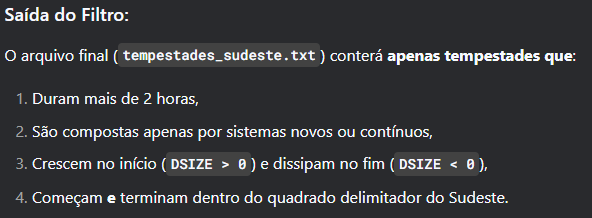

`Filtragens Aplicadas:`

1. TOTAL_TIME > 2.0 horas: Tempestades com duração superior a 2 horas

2. Classificação dos Sistemas (CLA): Apenas N (Novo) ou C (Contínuo). Exclui sistemas com M (Merged) ou S (Split)

2. Variação de Tamanho (DSIZE): Segunda linha: DSIZE > 0 (Crescimento inicial da tempestade) e Última linha: DSIZE < 0 (Dissipação final da tempestade)

3. Localização Geográfica (Sudeste do Brasil): Primeiro sistema: -25.0 ≤ XLAT ≤ -15.0 (Latitude) e -50.0 ≤ XLON ≤ -40.0 (Longitude). Ultimo sistema: Mesmos limites geográficos acima (Ambos os pontos devem estar dentro do quadrado delimitador)

In [3]:
def filtrar_familias(familias):

    familias_filtradas = []

    # Limites geográficos do Sudeste do Brasil (XLAT, XLON)
    sudeste_limites = { 'min_lat': -25.0,  # Mínima latitude
                        'max_lat': -15.0,  # Máxima latitude
                        'min_lon': -50.0,  # Mínima longitude
                        'max_lon': -40.0   # Máxima longitude
                      }

    for familia in familias:

        # Verifica se o resumo foi extraído corretamente
        if "resumo" not in familia or "TOTAL_TIME" not in familia["resumo"]:
            continue

        sistemas = familia["sistemas"]
        if len(sistemas) < 2:  # Ignora famílias com menos de 2 sistemas
            continue

        # Critério 1: Duração > 2 horas
        if familia["resumo"]["TOTAL_TIME"] <= 2.0:  # if familia["resumo"]["TOTAL_TIME"] <= 1.0:  # Tempestades >1h
            continue

        # Critério 2: CLA apenas 'N' ou 'C'
        clas_validas = {'N', 'C'}
        clas_presentes = {sistema.get("CLA", "") for sistema in sistemas}
        if not clas_presentes.issubset(clas_validas):
            continue

        # Critério 3: DSIZE da segunda linha positivo
        segundo_dsize = sistemas[1].get("DSIZE", "-999.9")
        try:
            segundo_dsize_float = float(segundo_dsize)
        except ValueError:
            segundo_dsize_float = -999.9
        if segundo_dsize_float <= 0:
            continue

        # Critério 4: DSIZE da última linha negativo
        ultimo_dsize = sistemas[-1].get("DSIZE", "-999.9")
        try:
            ultimo_dsize_float = float(ultimo_dsize)
        except ValueError:
            ultimo_dsize_float = -999.9
        if ultimo_dsize_float >= 0:
            continue

        # --- NOVO CRITÉRIO: Verifica localização inicial e final no Sudeste ---
        primeiro_sistema = sistemas[0]
        ultimo_sistema = sistemas[-1]

        # Extrai coordenadas do primeiro sistema
        try:
            lat_inicial = float(primeiro_sistema.get("XLAT", 0))
            lon_inicial = float(primeiro_sistema.get("XLON", 0))
        except ValueError:
            continue  # Ignora se não puder converter

        # Extrai coordenadas do último sistema
        try:
            lat_final = float(ultimo_sistema.get("XLAT", 0))
            lon_final = float(ultimo_sistema.get("XLON", 0))
        except ValueError:
            continue

        # Verifica se ambas as coordenadas estão no Sudeste
        dentro_sudeste_inicio = ( sudeste_limites['min_lat'] <= lat_inicial <= sudeste_limites['max_lat'] and
                                  sudeste_limites['min_lon'] <= lon_inicial <= sudeste_limites['max_lon'])

        dentro_sudeste_fim = ( sudeste_limites['min_lat'] <= lat_final <= sudeste_limites['max_lat'] and
                               sudeste_limites['min_lon'] <= lon_final <= sudeste_limites['max_lon'])

        if not (dentro_sudeste_inicio and dentro_sudeste_fim):
            continue  # Ignora se não estiver totalmente no Sudeste

        familias_filtradas.append(familia)

    return familias_filtradas

# Salvando as familias filtradas

In [4]:
def salvar_familias_filtradas(familias_filtradas, nome_arquivo_saida):

    with open(nome_arquivo_saida, 'w') as arquivo_saida:

        for familia in familias_filtradas:

            # Escreve o cabeçalho da família
            arquivo_saida.write(familia['cabecalho'] + '\n')

            # Escreve o cabeçalho dos dados (SYS#, XLAT, XLON, etc.)
            if familia['sistemas']:
                cabecalho_dados = ' '.join(familia['sistemas'][0].keys())
                arquivo_saida.write(cabecalho_dados + '\n')

                # Escreve os sistemas
                for sistema in familia['sistemas']:
                    linha = ' '.join(str(valor) for valor in sistema.values())
                    arquivo_saida.write(linha + '\n')

            # Escreve o resumo
            if 'resumo' in familia:
                resumo = familia['resumo']
                linha_resumo = ( f"TOTAL TIME= {resumo['TOTAL_TIME']:.2f}   "
                                 f"DELTAX {resumo['DELTAX']:.2f}   "
                                 f"DELTAY {resumo['DELTAY']:.2f}   "
                                 f"LAST IMAGE= {resumo['LAST_IMAGE']}   "
                                 f"END={resumo['END']}   "
                                 f"TOT_IC= {resumo['TOT_IC']}   "
                                 f"TOT_CGNEG= {resumo['TOT_CGNEG']}   "
                                 f"TOT_CGPOS= {resumo['TOT_CGPOS']}\n"
                                )
                arquivo_saida.write(linha_resumo)

            # Adiciona uma linha em branco entre famílias
            arquivo_saida.write('\n')

In [5]:
# arquivo de entrada e saída
filein = 'famraio_1701_s2.txt.gz'
fileou = 'famraio_1701_s2_filtrado.txt'

# leitura dos dados
dados = ler_fam_txt_gz(f'{dir_in}{filein}')

# filtragem dos dados
familias_filtradas = filtrar_familias(dados)

# salva as famílias filtradas em um novo arquivo
salvar_familias_filtradas(familias_filtradas, f'{dir_ou}{fileou}')

print(f"Famílias total: {len(dados)}")
print(f"Famílias filtradas: {len(familias_filtradas)}")

Famílias total: 25088
Famílias filtradas: 44


# Lendo o arquivo filtrado

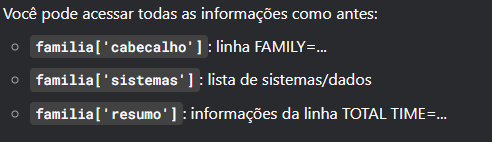

In [ ]:
# Usando a mesma função de leitura definida anteriormente
dados_filtrados = ler_fam_txt(f'{dir_ou}{fileou}')

# Exemplo de como acessar os dados
for i, familia in enumerate(dados_filtrados, 1):

    print(f"\n--- Família {i} ---")
    print(f"Cabeçalho: {familia['cabecalho']}")
    print(f"Duração: {familia['resumo']['TOTAL_TIME']} horas")
    print(f"Número de sistemas: {len(familia['sistemas'])}")

    # Exemplo: imprimir o primeiro e último sistema
    if familia['sistemas']:

        print("\nPrimeiro sistema:")
        print(familia['sistemas'][0])
        print("\nÚltimo sistema:")
        print(familia['sistemas'][-1])